In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import umap

In [2]:
# matplot setting

plt.rcParams["figure.figsize"] = (10,9)

In [76]:
# ori = pd.read_csv('./medical_concept_ICU(MIMIC)/mimic_valid_ver3.csv', index_col = 0)
# ori = ori.drop(['subject_id','charttime', 'stay_id', 'hadm_id', 'Annotation','circ_next_8h'], axis = 1)
ori = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/Case Labeling/mimic_df.csv.gz', index_col = 0, compression='gzip')

In [77]:
recovery_situation = {0, 1, 2, 3}
deterioration_situation = {0, 1, 3}

    
recover_state = ori[ori['classes'].isin(recovery_situation)].groupby('stay_id')['classes'].nunique()
recover_state = recover_state[recover_state == len(recovery_situation)].index

recover_set = ori[ori['stay_id'].isin(recover_state)]

deterioration_state = ori[ori['classes'].isin(deterioration_situation)].groupby('stay_id')['classes'].nunique()
deterioration_state = deterioration_state[deterioration_state == len(deterioration_situation)].index

deterioration_set = ori[ori['stay_id'].isin(deterioration_state)]

def filter_classes_with_condition(df):
    filtered_df = df[df['classes'].isin([0, 1, 3])]
    return filtered_df

deterioration_set = filter_classes_with_condition(deterioration_set)

deterioration_grouped = deterioration_set.groupby('stay_id')

# 조건에 맞는 stay_id를 찾는 함수
def deterioration_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인지 확인
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 마지막 관측치의 classes가 3인지 확인
        if group.tail(1)['classes'].iloc[0] == 3:
            return True
    return False

# 조건을 만족하는 stay_id 필터링
valid_stay_ids = [name for name, group in deterioration_grouped if deterioration_filter_stay_ids(group)]
deterioration_df = deterioration_set[deterioration_set.stay_id.isin(valid_stay_ids)].copy()

recover_grouped = recover_set.groupby('stay_id')

def recovery_filter_stay_ids(group):
    # 처음 3개 관측치의 Annotation이 모두 'no_circ'인 경우만 고려
    if all(group.head(3)['Annotation'] == 'no_circ'):
        # 'classes'가 2인 마지막 관측치 찾기
        last_class_2_index = group[group['classes'] == 2].index.max()
        if pd.notna(last_class_2_index):
            # 해당 인덱스까지의 데이터 반환
            return group.loc[:last_class_2_index]
    return pd.DataFrame()

# 조건을 만족하는 데이터 필터링
recovery_df = pd.concat([recovery_filter_stay_ids(group) for _, group in recover_grouped])

In [78]:
ori = pd.concat([recovery_df, deterioration_df])

In [80]:
class_ori = ori['classes'].values
reducer_ori = umap.UMAP()
umap_emb_ori = reducer_ori.fit_transform(ori.drop(['classes', 'Annotation'], axis = 1))

c:\Users\DAHS\anaconda3\envs\Umap_python\lib\site-packages\sklearn\manifold\_spectral_embedding.py:274: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


In [81]:
umap_emb_ori_df = pd.DataFrame(umap_emb_ori, columns = ['component 0', 'component 1'])
umap_emb_ori_df['classes'] = class_ori

In [28]:
umap_emb_ori_df.to_csv('original_data_space.csv', compression=='gzip')

In [27]:
embset = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/supervised_contrastive_learning/embedding_data_visual.csv.gz', index_col = 0, compression='gzip')
embset = embset.rename(columns ={'0.1':'classes'})

In [18]:
embset = embset.drop(['subject_id', 'stay_id', 'hadm_id'], axis =1 )
# ori = ori.drop(['subject_id', 'stay_id', 'hadm_id', 'Annotation', 'circ_next_12h'], axis =1 )

KeyError: "['subject_id', 'stay_id', 'hadm_id'] not found in axis"

In [29]:
class_feat = embset['classes'].values
reducer_feat = umap.UMAP()
umap_emb_feat = reducer_feat.fit_transform(embset.drop('classes', axis = 1))

In [30]:
umap_emb_feat_df = pd.DataFrame(umap_emb_feat, columns = ['component 0', 'component 1'])
umap_emb_feat_df['classes'] = class_feat

In [91]:
umap_emb_feat_df

component 0  component 1  classes
0         -3.796274    15.040869        1
1         -1.293838    14.530482        1
2          0.080824    15.494447        1
3          2.661217    14.460687        1
4          2.986061    15.365874        1
...             ...          ...      ...
125470     8.447816    18.370811        3
125471     9.021917    15.670810        3
125472     7.854437    17.757282        3
125473     8.193881    16.228596        3
125474     7.816811    17.213392        3

[125475 rows x 3 columns]

In [93]:
umap_emb_feat_df.to_csv('contrastive_data_space_case3_4.csv', compression='gzip')

In [58]:
# umap_emb_feat_df = pd.read_csv('contrastive_data_space.csv')

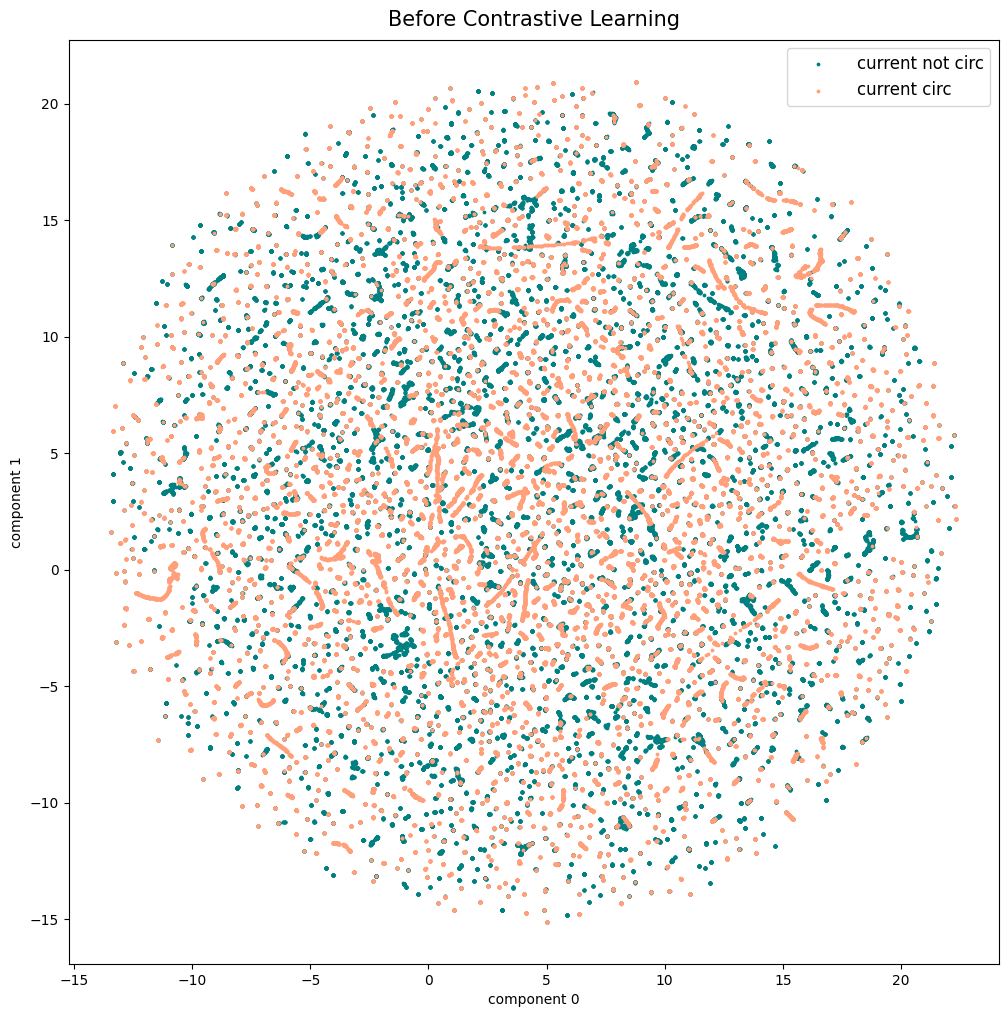

In [88]:
# target 별

# 분리
b_tsne_df_0 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 0]
b_tsne_df_1 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 1]
b_tsne_df_2 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 2]
b_tsne_df_3 = umap_emb_ori_df[umap_emb_ori_df['classes'] == 3]

# target 별 시각화
plt.scatter(b_tsne_df_0['component 0'], b_tsne_df_0['component 1'], color = 'teal', s=3)
plt.scatter(b_tsne_df_1['component 0'], b_tsne_df_1['component 1'], color = 'teal', label = 'current not circ', s=3)
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'lightsalmon', s=3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'lightsalmon', label = 'current circ', s=3)

plt.title('Before Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

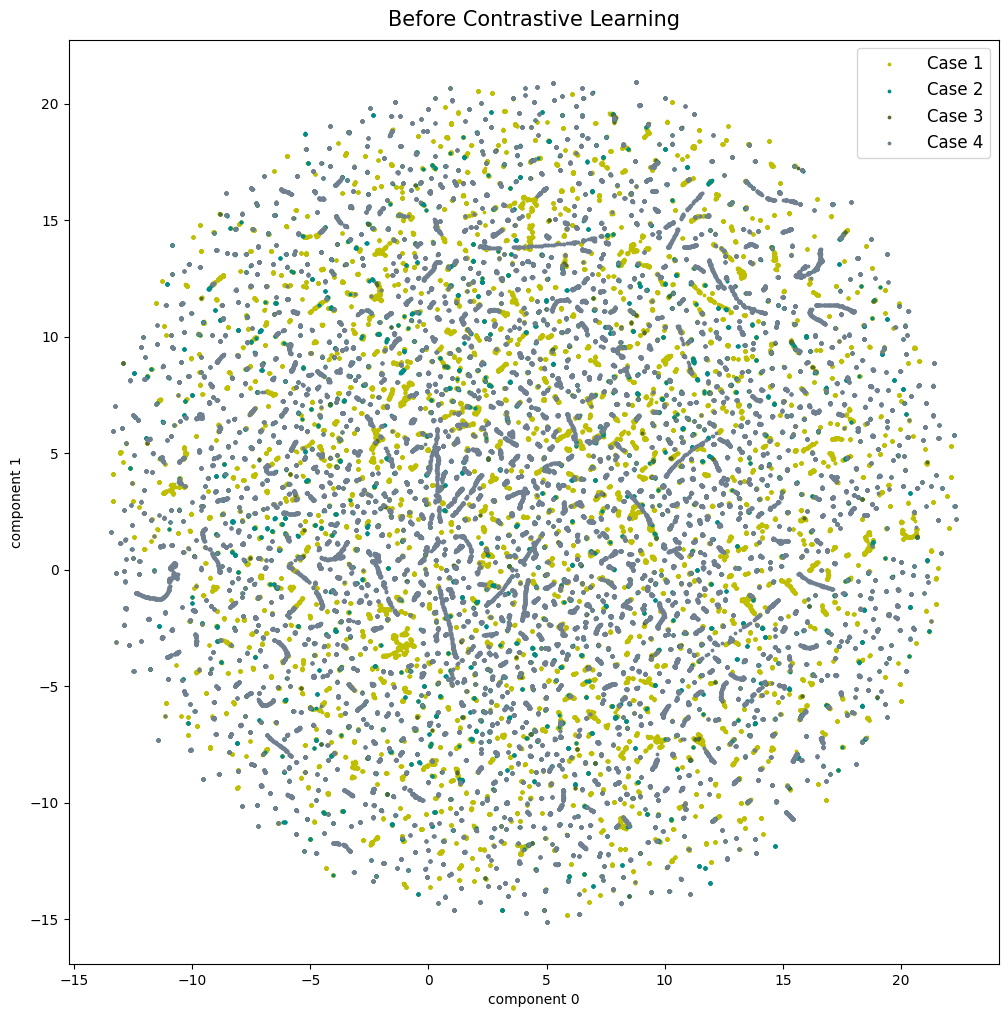

In [90]:
# target 별 시각화
plt.scatter(b_tsne_df_0['component 0'], b_tsne_df_0['component 1'], color = 'y', label = 'Case 1', s = 3)
plt.scatter(b_tsne_df_1['component 0'], b_tsne_df_1['component 1'], color = 'darkcyan', label = 'Case 2', s = 3)
plt.scatter(b_tsne_df_2['component 0'], b_tsne_df_2['component 1'], color = 'darkolivegreen', label = 'Case 3', s = 3)
plt.scatter(b_tsne_df_3['component 0'], b_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s = 3)

plt.title('Before Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

In [25]:
umap_emb_feat_df

component 0  component 1   classes
0         12.494147    16.317533  0.024721
1         11.039611    15.221177  0.000003
2         10.081041    15.596335  0.016885
3          9.282590    14.393867  0.002973
4          8.661252    14.845791  0.027437
...             ...          ...       ...
125470     8.147216    20.098482  0.022864
125471     6.696028    18.351896  0.028518
125472     7.340895    20.219017  0.022982
125473     6.498904    18.971405  0.026786
125474     6.838697    19.927597  0.024549

[125475 rows x 3 columns]

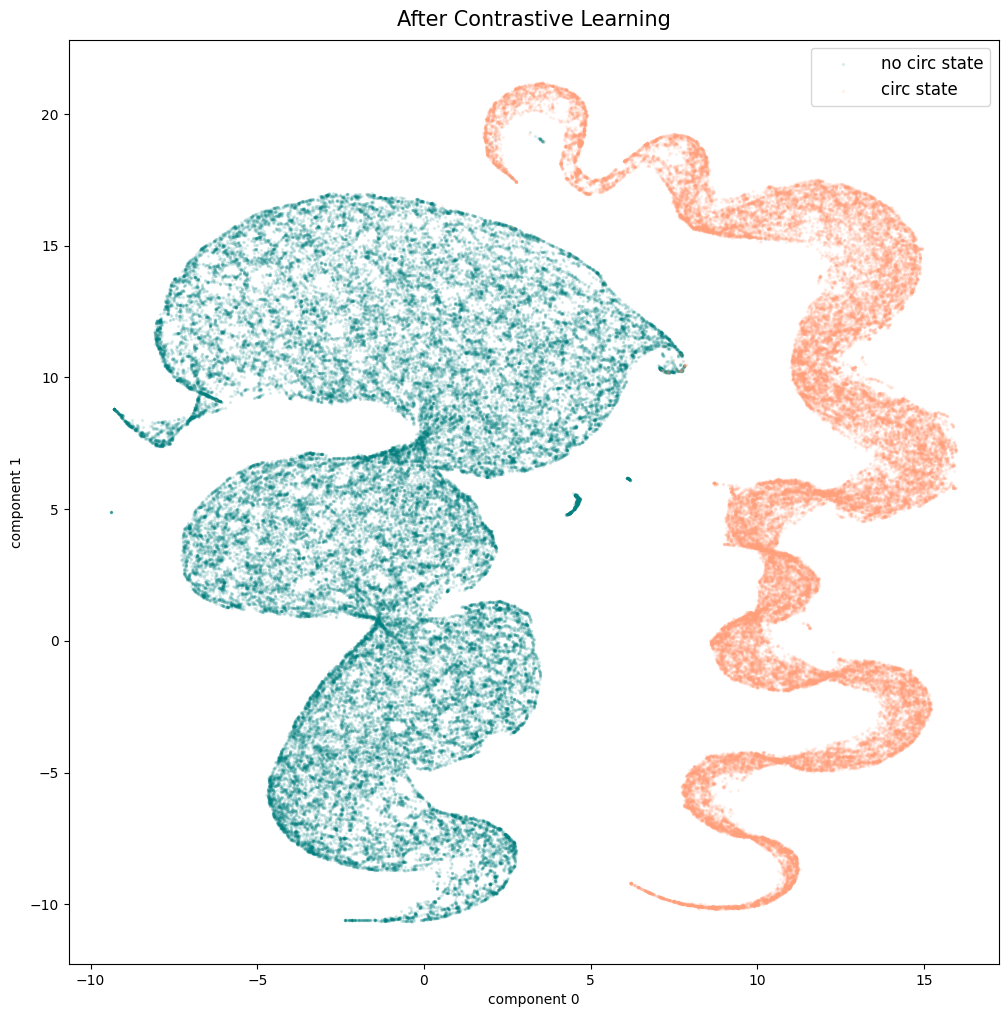

In [89]:
plt.rcParams["figure.figsize"] = (12,12)
# target 별 분리
c_tsne_df_0 = umap_emb_feat_df[umap_emb_feat_df['classes'] == 0]
c_tsne_df_1 = umap_emb_feat_df[umap_emb_feat_df['classes'] == 1]
c_tsne_df_2 = umap_emb_feat_df[umap_emb_feat_df['classes'] == 2]
c_tsne_df_3 = umap_emb_feat_df[umap_emb_feat_df['classes'] == 3]

# target 별 시각화
plt.scatter(c_tsne_df_0['component 0'], c_tsne_df_0['component 1'], color = 'teal', s = 2, alpha=0.1)
plt.scatter(c_tsne_df_1['component 0'], c_tsne_df_1['component 1'], color = 'teal', label = 'no circ state', s = 2, alpha=0.1)
plt.scatter(c_tsne_df_2['component 0'], c_tsne_df_2['component 1'], color = 'lightsalmon', s = 1, alpha=0.1)
plt.scatter(c_tsne_df_3['component 0'], c_tsne_df_3['component 1'], color = 'lightsalmon', label = 'circ state', s = 2, alpha=0.1)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

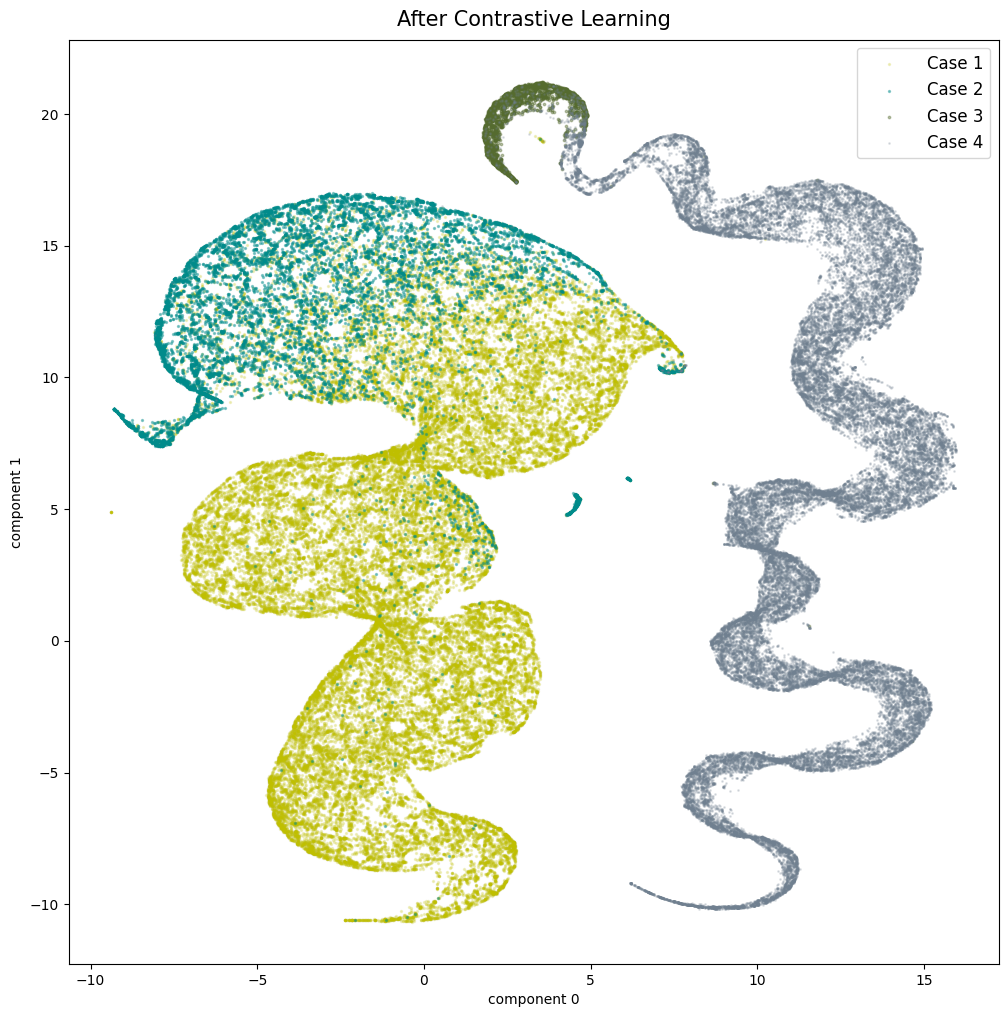

In [71]:
# plt.rcParams["figure.figsize"] = (10,9)
plt.rcParams["figure.figsize"] = (12,12)

# target 별 시각화
plt.scatter(c_tsne_df_0['component 0'], c_tsne_df_0['component 1'], color = 'y', label = 'Case 1', s = 2, alpha=0.2)
plt.scatter(c_tsne_df_1['component 0'], c_tsne_df_1['component 1'], color = 'darkcyan', label = 'Case 2', s = 2, alpha=0.4)
plt.scatter(c_tsne_df_2['component 0'], c_tsne_df_2['component 1'], color = 'darkolivegreen', label = 'Case 3', s = 3, alpha=0.4)
plt.scatter(c_tsne_df_3['component 0'], c_tsne_df_3['component 1'], color = 'slategray', label = 'Case 4', s = 1, alpha=0.2)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

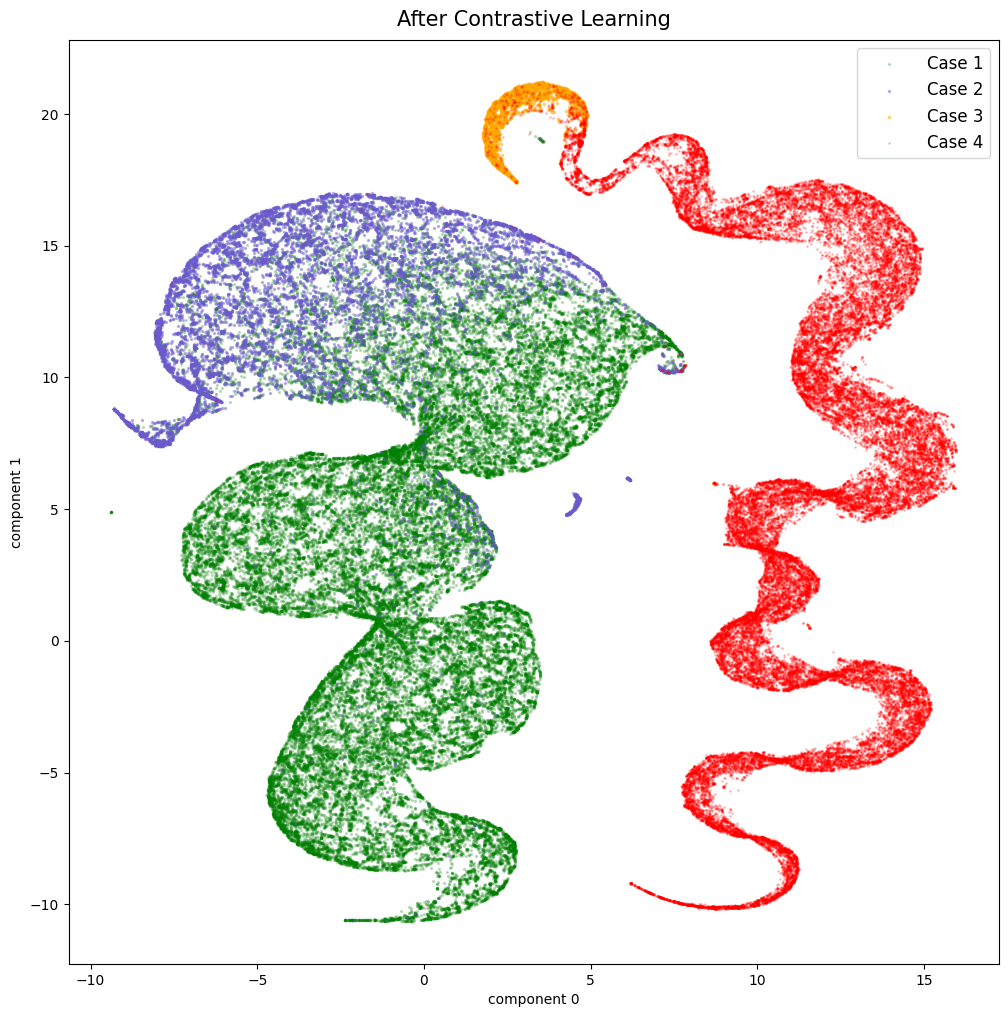

In [74]:
plt.rcParams["figure.figsize"] = (12,12)

# target 별 시각화
plt.scatter(c_tsne_df_0['component 0'], c_tsne_df_0['component 1'], color = 'green', label = 'Case 1', s = 2, alpha=0.2)
plt.scatter(c_tsne_df_1['component 0'], c_tsne_df_1['component 1'], color = 'slateblue', label = 'Case 2', s = 2, alpha=0.4)
plt.scatter(c_tsne_df_2['component 0'], c_tsne_df_2['component 1'], color = 'orange', label = 'Case 3', s = 3, alpha=0.4)
plt.scatter(c_tsne_df_3['component 0'], c_tsne_df_3['component 1'], color = 'red', label = 'Case 4', s = 1, alpha=0.2)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

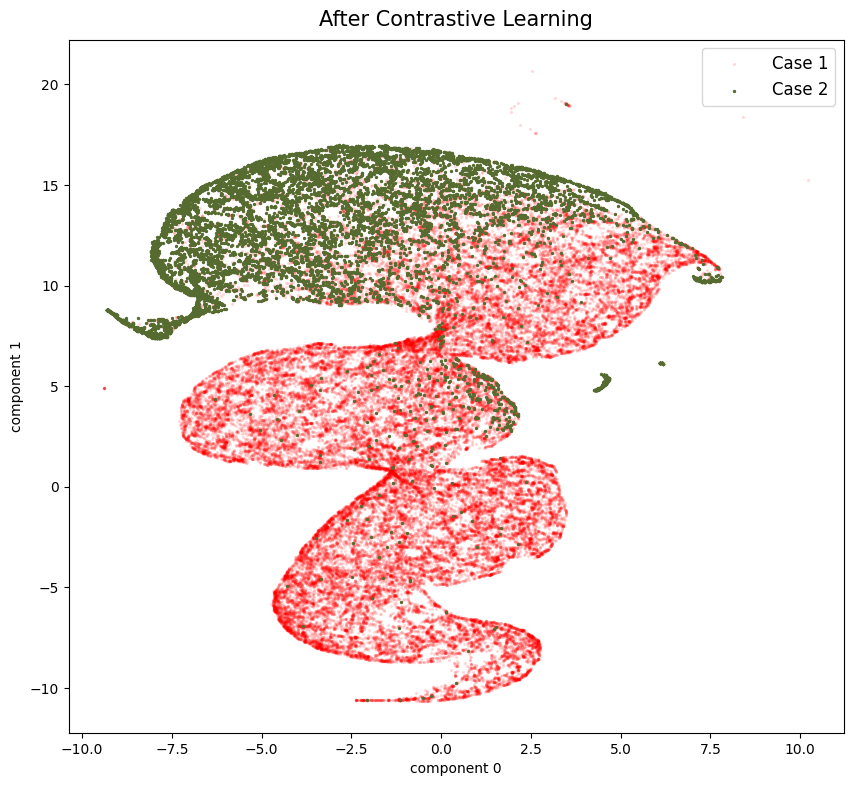

In [34]:
plt.scatter(c_tsne_df_0['component 0'], c_tsne_df_0['component 1'], color = 'red', label = 'Case 1', s = 2, alpha=0.1)
plt.scatter(c_tsne_df_1['component 0'], c_tsne_df_1['component 1'], color = 'darkolivegreen', label = 'Case 2', s = 2, alpha=1)
# plt.scatter(c_tsne_df_2['component 0'], c_tsne_df_2['component 1'], color = 'navy', label = 'Case 3', s = 3, alpha=1)
# plt.scatter(c_tsne_df_3['component 0'], c_tsne_df_3['component 1'], color = 'orchid', label = 'Case 4', s = 1, alpha=0.1)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

In [35]:
embset_total = pd.read_csv('/Users/DAHS/MIMIC-IV-Data-Pipeline/MIMIC_pipeline/supervised_contrastive_learning/embedding_data.csv.gz', index_col = 0, compression='gzip')
embset_total = embset_total.rename(columns ={'43':'classes'})
embset_total = embset_total.drop(['subject_id', 'stay_id', 'hadm_id'], axis =1 )

class_feat = embset_total['classes'].values
reducer_feat = umap.UMAP()
umap_emb_feat_total = reducer_feat.fit_transform(embset_total.drop('classes', axis = 1))

umap_emb_feat_df_total = pd.DataFrame(umap_emb_feat_total, columns = ['component 0', 'component 1'])
umap_emb_feat_df_total['classes'] = class_feat

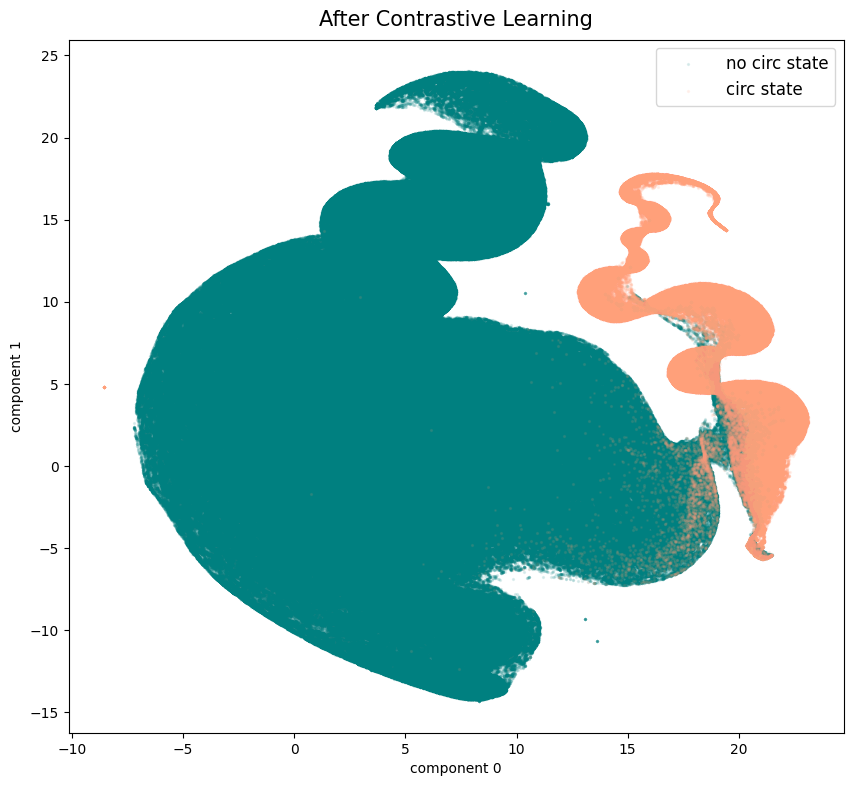

In [36]:
# target 별 분리
c_tsne_df_0_total = umap_emb_feat_df_total[umap_emb_feat_df_total['classes'] == 0]
c_tsne_df_1_total = umap_emb_feat_df_total[umap_emb_feat_df_total['classes'] == 1]
c_tsne_df_2_total = umap_emb_feat_df_total[umap_emb_feat_df_total['classes'] == 2]
c_tsne_df_3_total = umap_emb_feat_df_total[umap_emb_feat_df_total['classes'] == 3]

# target 별 시각화
plt.scatter(c_tsne_df_0_total['component 0'], c_tsne_df_0_total['component 1'], color = 'teal', s = 2, alpha=0.1)
plt.scatter(c_tsne_df_1_total['component 0'], c_tsne_df_1_total['component 1'], color = 'teal', label = 'no circ state', s = 2, alpha=0.1)
plt.scatter(c_tsne_df_2_total['component 0'], c_tsne_df_2_total['component 1'], color = 'lightsalmon', s = 1, alpha=0.1)
plt.scatter(c_tsne_df_3_total['component 0'], c_tsne_df_3_total['component 1'], color = 'lightsalmon', label = 'circ state', s = 2, alpha=0.1)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

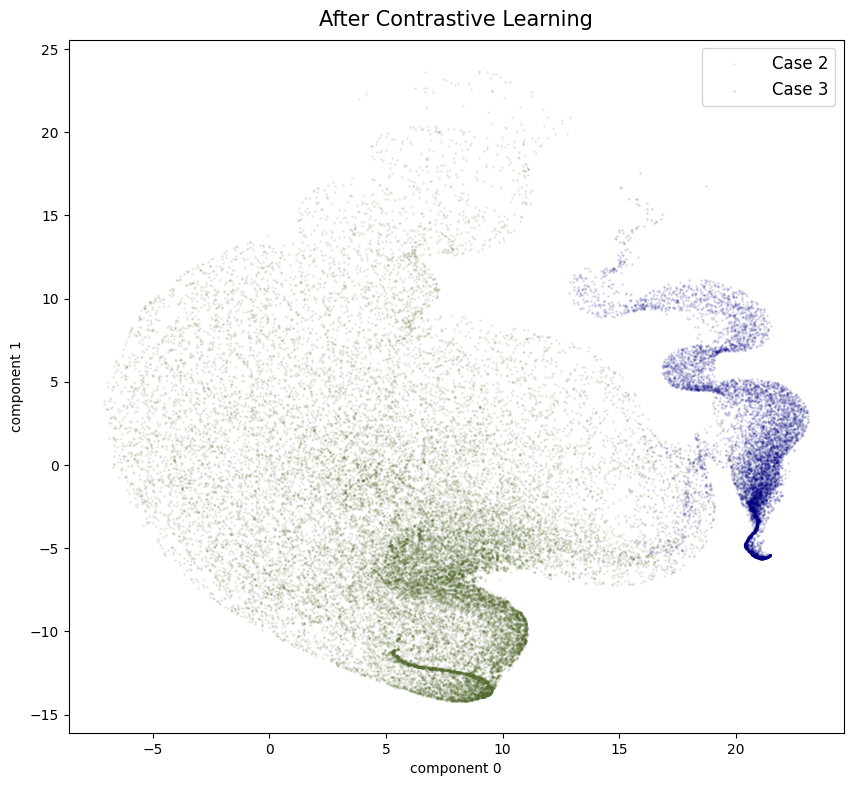

In [42]:
# target 별 시각화
# plt.scatter(c_tsne_df_0_total['component 0'], c_tsne_df_0_total['component 1'], color = 'red', label = 'Case 1', s = 0.5, alpha=0.1)
plt.scatter(c_tsne_df_1_total['component 0'], c_tsne_df_1_total['component 1'], color = 'darkolivegreen', label = 'Case 2', s = 1, alpha=0.1)
plt.scatter(c_tsne_df_2_total['component 0'], c_tsne_df_2_total['component 1'], color = 'navy', label = 'Case 3', s = 1, alpha=0.1)
# plt.scatter(c_tsne_df_3_total['component 0'], c_tsne_df_3_total['component 1'], color = 'orchid', label = 'Case 4', s = 1, alpha=0.1)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()

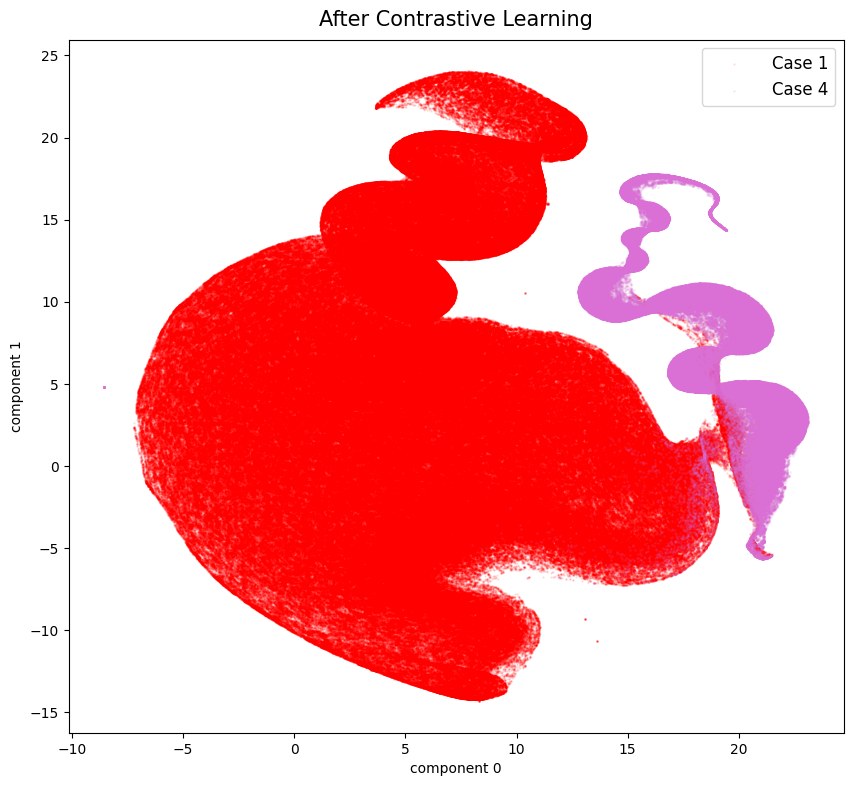

In [43]:
# target 별 시각화
plt.scatter(c_tsne_df_0_total['component 0'], c_tsne_df_0_total['component 1'], color = 'red', label = 'Case 1', s = 0.5, alpha=0.1)
# plt.scatter(c_tsne_df_1_total['component 0'], c_tsne_df_1_total['component 1'], color = 'darkolivegreen', label = 'Case 2', s = 1, alpha=0.1)
# plt.scatter(c_tsne_df_2_total['component 0'], c_tsne_df_2_total['component 1'], color = 'navy', label = 'Case 3', s = 1, alpha=0.1)
plt.scatter(c_tsne_df_3_total['component 0'], c_tsne_df_3_total['component 1'], color = 'orchid', label = 'Case 4', s = 1, alpha=0.1)

plt.title('After Contrastive Learning', pad = 10, fontsize=15)
plt.xlabel('component 0')
plt.ylabel('component 1')
plt.legend(fontsize=12, handlelength=3)
plt.show()